In [1]:
 %pip install gym[accept-rom-license]
 %pip install ale-py
 %pip install gymnasium[atari]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=9a9ac0deba86b9e7543920c27b2241537320e0044bd09e613931ef0964be98ef
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.5 MB/s eta 0:00:00
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import files


Mounted at /content/drive


In [3]:
import gymnasium as gym
import ale_py

env = gym.make('ALE/Pong-v5', render_mode="rgb_array")

print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

env.close()


Action Space: Discrete(6)
Observation Space: Box(0, 255, (210, 160, 3), uint8)


In [4]:
import numpy as np


num_episodes = 5
env = gym.make('ALE/Pong-v5', render_mode="rgb_array")

for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward

        if done or truncated:
            print(f"Episode {episode + 1} reward: {episode_reward}")
            break

env.close()


Episode 1 reward: -20.0
Episode 2 reward: -19.0
Episode 3 reward: -21.0
Episode 4 reward: -21.0
Episode 5 reward: -20.0


In [5]:
import cv2
import numpy as np

def preprocess_frame(frame, last_frame=None):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    gray_frame = cv2.resize(gray_frame, (84, 84))

    gray_frame = gray_frame.astype(np.float32) / 255.0

    if last_frame is not None:
        last_frame = last_frame.astype(np.float32)
        gray_frame = cv2.absdiff(gray_frame, last_frame)

    return gray_frame


In [6]:
class DQNetwork(nn.Module):
    def __init__(self, action_space):
        super(DQNetwork, self).__init__()
        self.action_space = action_space
        self.conv1 = nn.Conv2d(2, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, experience):
        """Adds experience to the buffer"""
        self.buffer.append(experience)

    def sample(self, batch_size):
        """Samples a batch of experiences from the buffer"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [8]:
CHECKPOINT_PATH = '/content/drive/MyDrive/dqn_checkpoints/'
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

def save_checkpoint(policy_net, target_net, optimizer, episode, filename="dqn_checkpoint.pth"):
    checkpoint = {
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_PATH, filename))
    print(f"Checkpoint saved at episode {episode}.")

def load_checkpoint(filename="dqn_checkpoint.pth"):
    filepath = os.path.join(CHECKPOINT_PATH, filename)
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        target_net.load_state_dict(checkpoint['target_net_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode'] + 1
        print(f"Checkpoint loaded. Resuming from episode {start_episode}.")
        return start_episode
    else:
        print("No checkpoint found. Starting from scratch.")
        return 1


In [10]:

num_episodes = 930
learning_rate = 1e-4
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
target_update_interval = 10


memory = ReplayBuffer(capacity=10000)
episode_rewards = []

action_space = env.action_space.n


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


policy_net = DQNetwork(action_space).to(device)
target_net = DQNetwork(action_space).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)


start_episode = load_checkpoint()



No checkpoint found. Starting from scratch.


In [11]:
for episode in range(start_episode, num_episodes + 1):
    obs, _ = env.reset()
    last_frame = None
    done = False
    episode_reward = 0

    while not done:
        frame = preprocess_frame(obs, last_frame)
        state = np.stack((frame, last_frame), axis=0) if last_frame is not None else np.stack((frame, frame), axis=0)
        last_frame = frame

        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            action = torch.argmax(q_values).item()

        next_obs, reward, done, truncated, _ = env.step(action)
        episode_reward += reward

        next_frame = preprocess_frame(next_obs, last_frame)
        next_state = np.stack((next_frame, frame), axis=0)

        memory.push((state, action, reward, next_state, done))

        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)
            states = torch.FloatTensor(np.array(states)).to(device).view(batch_size, 2, 84, 84)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(np.array(next_states)).to(device).view(batch_size, 2, 84, 84)
            dones = torch.FloatTensor(dones).to(device)

            current_q_values = policy_net(states).gather(1, actions)

            with torch.no_grad():
                max_next_q_values = target_net(next_states).max(1)[0]
                target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

            loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        obs = next_obs

        if episode % target_update_interval == 0:
            target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode}: Reward = {episode_reward}")
    episode_rewards.append(episode_reward)


    if episode % 20 == 0:
        save_checkpoint(policy_net, target_net, optimizer, episode)

env.close()


Episode 1: Reward = -20.0
Episode 2: Reward = -20.0
Episode 3: Reward = -20.0
Episode 4: Reward = -21.0
Episode 5: Reward = -19.0
Episode 6: Reward = -21.0
Episode 7: Reward = -21.0
Episode 8: Reward = -20.0
Episode 9: Reward = -20.0
Episode 10: Reward = -19.0
Episode 11: Reward = -20.0
Episode 12: Reward = -20.0
Episode 13: Reward = -20.0
Episode 14: Reward = -19.0
Episode 15: Reward = -20.0
Episode 16: Reward = -20.0
Episode 17: Reward = -20.0
Episode 18: Reward = -20.0
Episode 19: Reward = -20.0
Episode 20: Reward = -21.0
Checkpoint saved at episode 20.
Episode 21: Reward = -21.0
Episode 22: Reward = -19.0
Episode 23: Reward = -21.0
Episode 24: Reward = -21.0
Episode 25: Reward = -20.0
Episode 26: Reward = -21.0
Episode 27: Reward = -21.0
Episode 28: Reward = -21.0
Episode 29: Reward = -21.0
Episode 30: Reward = -19.0
Episode 31: Reward = -20.0
Episode 32: Reward = -21.0
Episode 33: Reward = -19.0
Episode 34: Reward = -21.0
Episode 35: Reward = -20.0
Episode 36: Reward = -20.0
Episo

In [ ]:

episode_rewards_checkpoint = {
    'episode_rewards': episode_rewards
}
torch.save(episode_rewards_checkpoint, 'pong_episode_rewards.pth')
print("Episode rewards saved separately.")


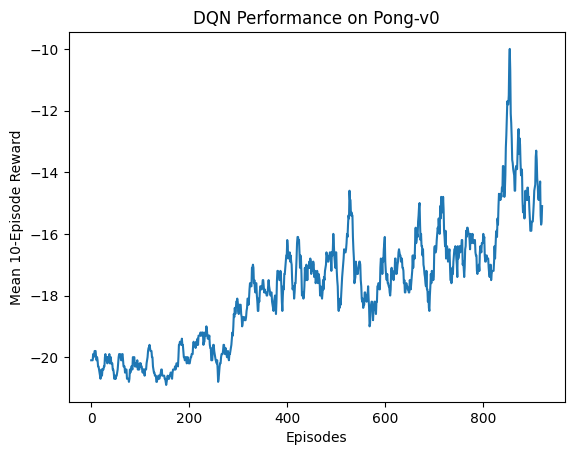

In [15]:
import matplotlib.pyplot as plt


n = 10
mean_rewards = [np.mean(episode_rewards[i:i+n]) for i in range(len(episode_rewards) - n + 1)]

plt.plot(mean_rewards)
plt.xlabel("Episodes")
plt.ylabel(f"Mean {n}-Episode Reward")
plt.title("DQN Performance on Pong-v0")
plt.show()


In the above graph, we observe that the mean reward gradually approaches zero as the number of episodes increases. Additionally, the variation around the mean reward decreases over time, as indicated by the narrowing spread in the graph toward the right. Based on these trends, we can extrapolate that, after a certain number of episodes, the reward curve will converge to a zero-reward baseline, indicating stabilization in the agent's performance.
Due to ristriction in computational resources this was the maximum that i was able to plot.